# **Newtwork Analysis of MCU**

In [ ]:
# !pip install python-louvain
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from community import community_louvain

# ------------------------------------------------------------------------------
# Step 1: Load the datasets
# ------------------------------------------------------------------------------
nodes = pd.read_csv('/nodes.csv')
edges = pd.read_csv('/edges.csv')
hero_network = pd.read_csv('/hero-network.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# ------------------------------------------------------------------------------
# Step 2: Analyze connections between heroes and comics
# ------------------------------------------------------------------------------

# How many times each hero appears in each comic
hero_comic_connections = edges.groupby(['hero', 'comic']).size()

# Find comics with most hero appearances (Determine Major events perhaps)
comic_popularity = edges['comic'].value_counts()

# Identify key heroes by their appearances in different comics
hero_uniqueness = edges.groupby('hero')['comic'].nunique()

# Display the top comics by the number of appearances and the top heroes by unique comic appearances
print("Top Comics by Number of Hero Appearances:")
print(comic_popularity.head(10), "\n")
print("Top Heroes by Unique Comic Appearances:")
print(hero_uniqueness.nlargest(10), "\n")

Top Comics by Number of Hero Appearances:
comic
COC 1       111
IW 3         91
IW 1         90
H2 279       87
IW 4         80
IW 2         76
MAXSEC 3     72
FF 370       62
IW 6         60
M/GN 1       60
Name: count, dtype: int64 

Top Heroes by Unique Comic Appearances:
hero
SPIDER-MAN/PETER PARKER    1577
CAPTAIN AMERICA            1334
IRON MAN/TONY STARK        1150
THING/BENJAMIN J. GR        963
THOR/DR. DONALD BLAK        956
HUMAN TORCH/JOHNNY S        886
MR. FANTASTIC/REED R        854
HULK/DR. ROBERT BRUC        835
WOLVERINE/LOGAN             819
INVISIBLE WOMAN/SUE         762
Name: comic, dtype: int64 



In [ ]:
# ------------------------------------------------------------------------------
# Step 3: Determine the popularity of characters based on appearances and connections
# ------------------------------------------------------------------------------

# Count the number of appearances of each character in comics
character_appearances = edges['hero'].value_counts()

# Count connections in both 'hero1' and 'hero2' columns from the data
hero1_connections = hero_network['hero1'].value_counts()
hero2_connections = hero_network['hero2'].value_counts()
hero_connections = hero1_connections.add(hero2_connections, fill_value=0)

# Combine the counts of appearances and connections to determine popularity
popularity_scores = character_appearances.add(hero_connections, fill_value=0)

# Print top 10 most popular characters based on combined score
print("Top 10 Most Popular Characters Based on Appearances and Connections:")
print(popularity_scores.nlargest(10), "\n")

Top 10 Most Popular Characters Based on Appearances and Connections:
CAPTAIN AMERICA         17833.0
SPIDER-MAN/PETER PAR    13717.0
THOR/DR. DONALD BLAK    12383.0
IRON MAN/TONY STARK     11817.0
THING/BENJAMIN J. GR    11644.0
HUMAN TORCH/JOHNNY S    11123.0
MR. FANTASTIC/REED R    10629.0
WOLVERINE/LOGAN         10353.0
BEAST/HENRY &HANK& P     9922.0
SCARLET WITCH/WANDA      9911.0
Name: count, dtype: float64 



Top 25 Most Popular Characters:
CAPTAIN AMERICA         17833.0
SPIDER-MAN/PETER PAR    13717.0
THOR/DR. DONALD BLAK    12383.0
IRON MAN/TONY STARK     11817.0
THING/BENJAMIN J. GR    11644.0
HUMAN TORCH/JOHNNY S    11123.0
MR. FANTASTIC/REED R    10629.0
WOLVERINE/LOGAN         10353.0
BEAST/HENRY &HANK& P     9922.0
SCARLET WITCH/WANDA      9911.0
VISION                   9696.0
CYCLOPS/SCOTT SUMMER     9684.0
INVISIBLE WOMAN/SUE      9326.0
STORM/ORORO MUNROE S     9318.0
HAWK                     9088.0
WASP/JANET VAN DYNE      8426.0
HULK/DR. ROBERT BRUC     8350.0
COLOSSUS II/PETER RA     8315.0
ANT-MAN/DR. HENRY J.     7904.0
PROFESSOR X/CHARLES      7840.0
MARVEL GIRL/JEAN GRE     7413.0
ANGEL/WARREN KENNETH     7368.0
WONDER MAN/SIMON WIL     7066.0
NIGHTCRAWLER/KURT WA     6633.0
SHE-HULK/JENNIFER WA     6589.0
Name: count, dtype: float64 



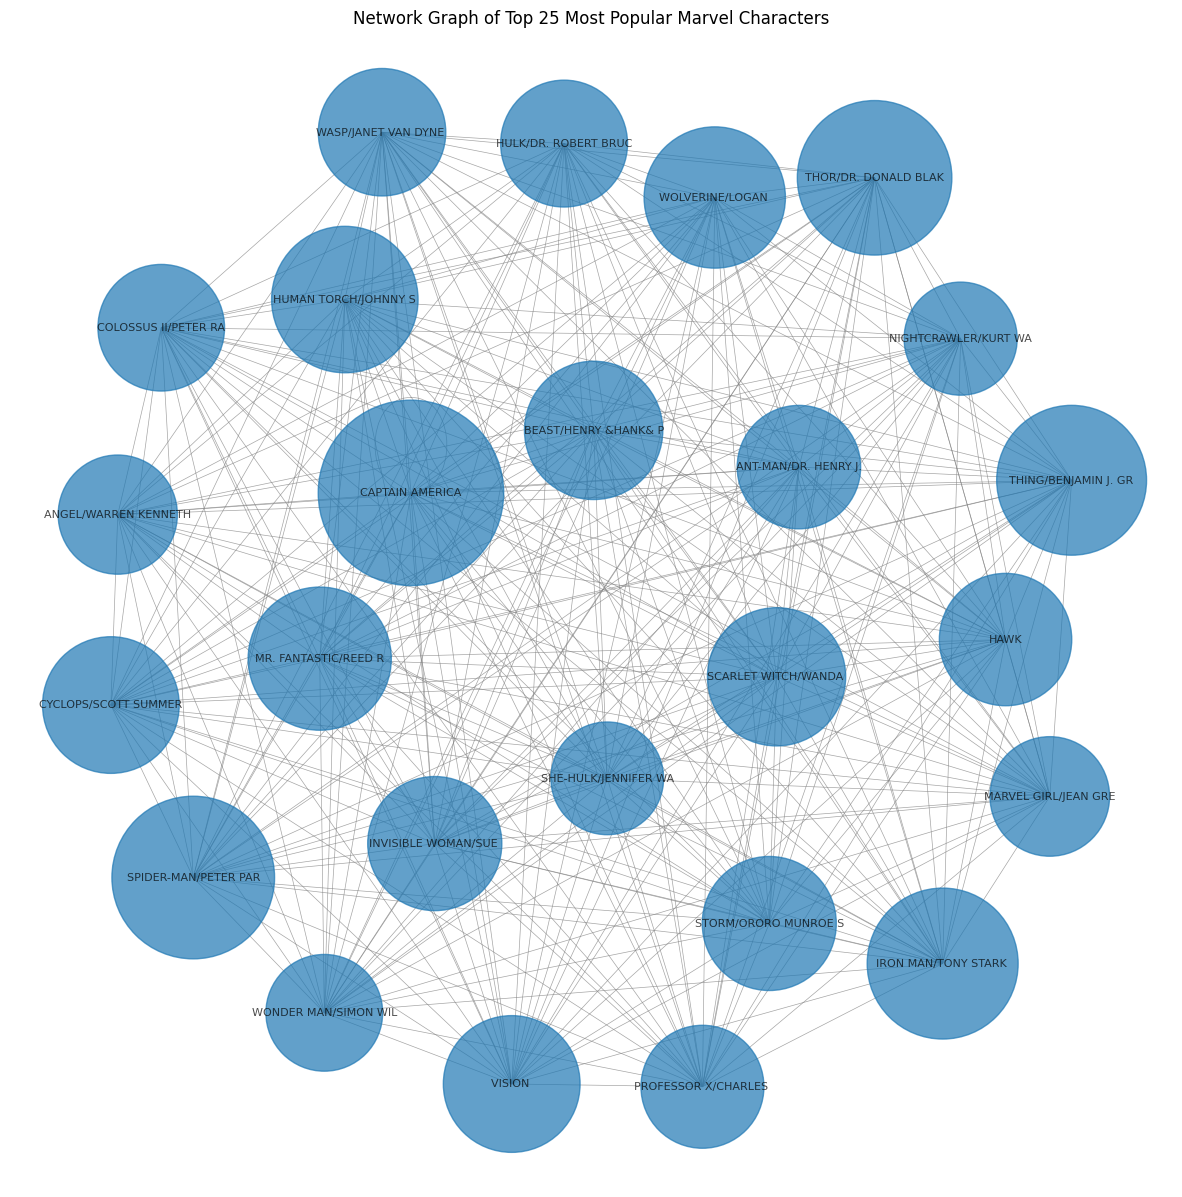

<Figure size 640x480 with 0 Axes>

In [ ]:
# ------------------------------------------------------------------------------
# Step 4: Select the top 25 most popular characters
# ------------------------------------------------------------------------------

top_25_popular_characters = popularity_scores.nlargest(25)
print("Top 25 Most Popular Characters:")
print(top_25_popular_characters, "\n")


# ------------------------------------------------------------------------------
# Step 5: Create a network graph of the top 25 popular characters and their connections
# ------------------------------------------------------------------------------

# Generate a list of the top 25 popular characters
popular_characters = top_25_popular_characters.index.tolist()

# Filter the hero-network dataset to include only connections between these top characters
popular_hero_edges = hero_network[(hero_network['hero1'].isin(popular_characters)) |
                                  (hero_network['hero2'].isin(popular_characters))]

# Create Graph
G = nx.Graph()

# Add Nodes
for character in popular_characters:
  # node size based on their popularity
    G.add_node(character, size=top_25_popular_characters[character])

# Add edges
for _, row in popular_hero_edges.iterrows():
    if row['hero1'] in popular_characters and row['hero2'] in popular_characters:
        G.add_edge(row['hero1'], row['hero2'])

# Get node positions
pos = nx.spring_layout(G)

# Draw the network
plt.figure(figsize=(15, 15))
node_sizes = [G.nodes[node]['size'] for node in G]  # Adjust the multiplier as needed
nx.draw_networkx(G, pos, with_labels=True, node_size=node_sizes, alpha=0.7,
                 edge_color='gray', width=0.5, font_size=8)

plt.title('Network Graph of Top 25 Most Popular Marvel Characters')
plt.axis('off')
plt.show()
plt.savefig("Top_25_characters.png")

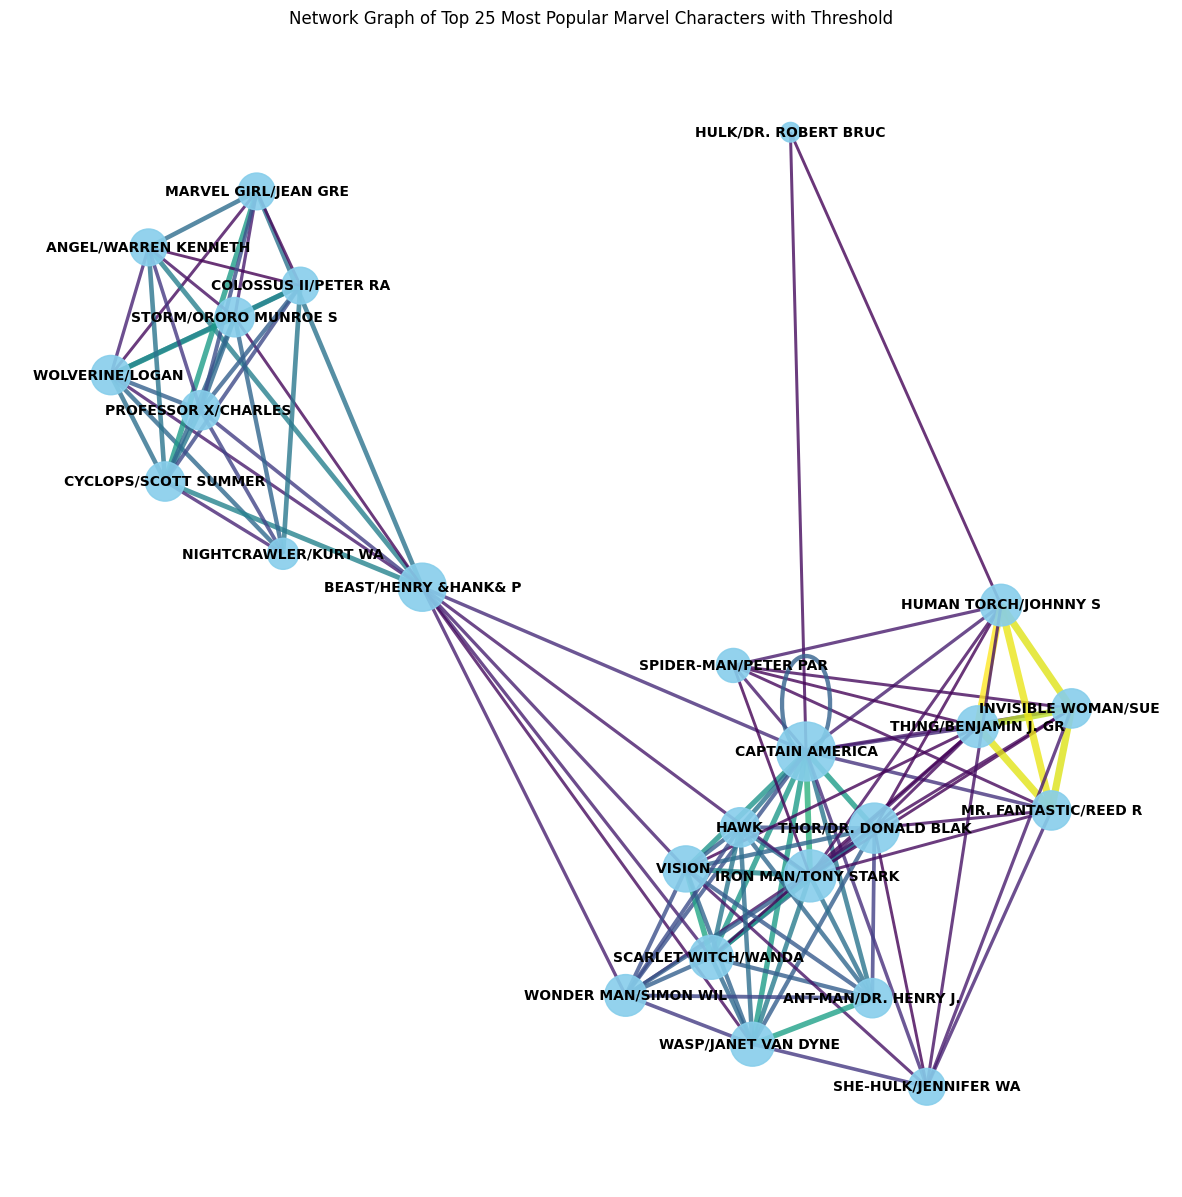

In [ ]:
# ------------------------------------------------------------------------------
# Step 6: Redefine graph with connection threshold
# ------------------------------------------------------------------------------

# Calculate the frequency of each hero pair appearing together
hero_pair_frequency = hero_network.groupby(['hero1', 'hero2']).size().reset_index(name='frequency')

# Get the top # of connections
top_connections_number = int(len(hero_pair_frequency) * 0.0025)

# Sort the pairs by frequency
significant_hero_pairs = hero_pair_frequency.nlargest(top_connections_number, 'frequency')


# Create a new graph based on the significant hero pairs
H = nx.Graph()
H.add_nodes_from(popular_characters)
max_weight = max(significant_hero_pairs['frequency'])

for _, row in significant_hero_pairs.iterrows():
    if row['hero1'] in popular_characters and row['hero2'] in popular_characters:
        # Add the edge with the 'frequency' as the weight
        weight = row['frequency'] / max_weight
        H.add_edge(row['hero1'], row['hero2'], weight=weight)

# Draw the network
pos = nx.spring_layout(H, k=.65, iterations=100, seed=12)
plt.figure(figsize=(15, 15))
edge_widths = [H[u][v]['weight']**0.5 * 10 for u,v in H.edges()]
nx.draw_networkx_edges(H, pos, alpha=0.8, edge_color=edge_widths, edge_cmap=plt.cm.viridis, width=edge_widths)

node_sizes = [H.degree(node) * 100 for node in H]  # Draws nodes with size proportional to their degree
nx.draw_networkx_nodes(H, pos, node_size=node_sizes, node_color='skyblue', alpha=0.9)

nx.draw_networkx_labels(H, pos, font_size=10, font_color='black', font_weight='bold')

plt.title('Network Graph of Top 25 Most Popular Marvel Characters with Threshold')
plt.axis('off')
plt.show()

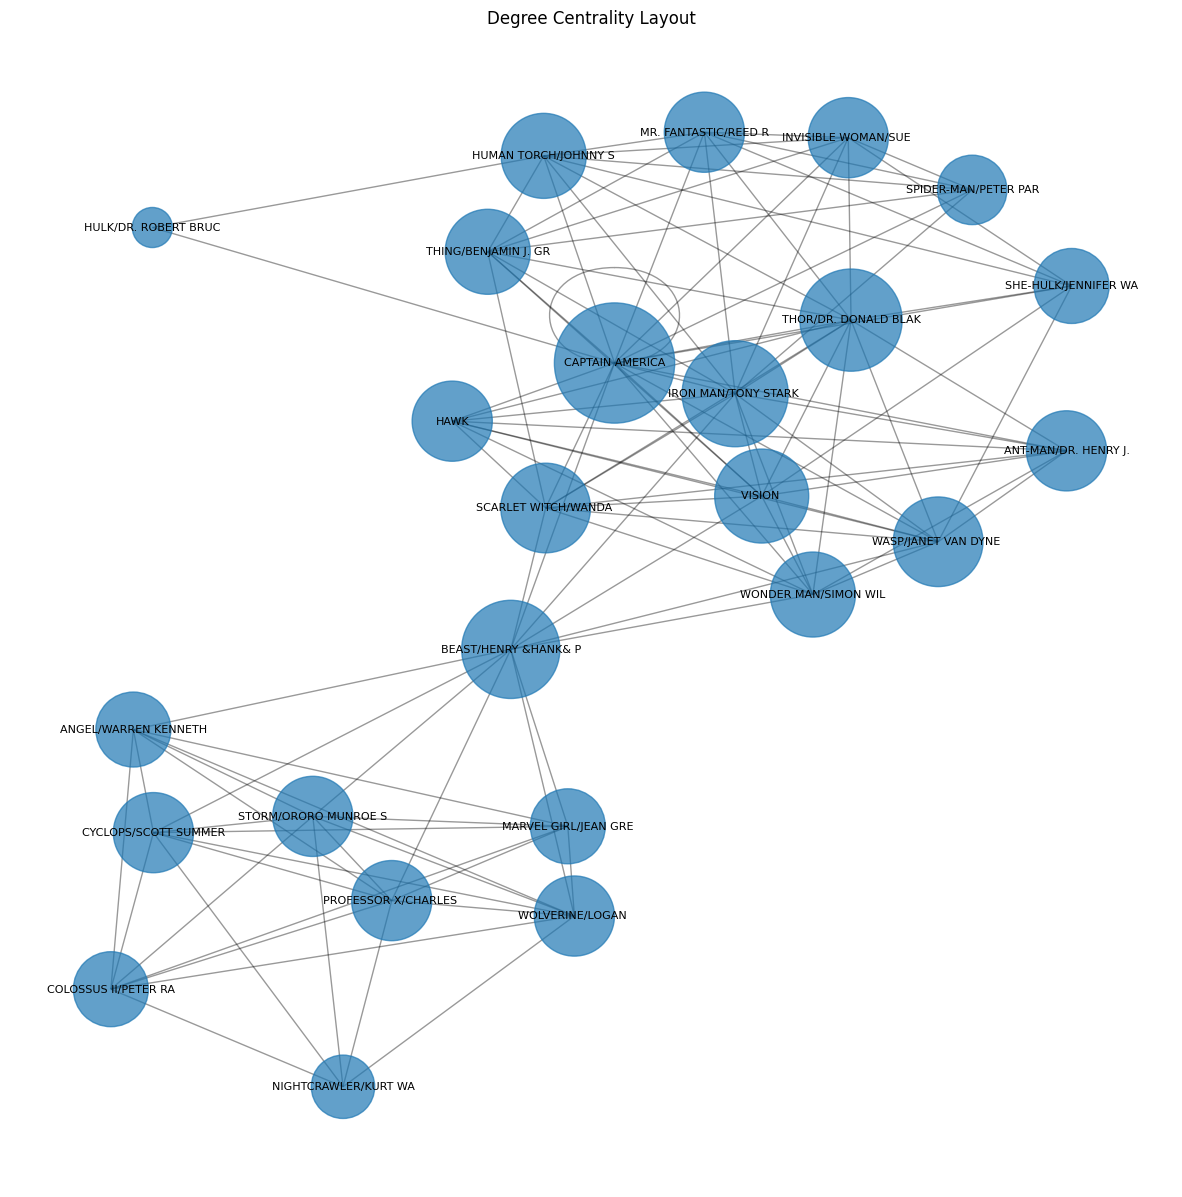

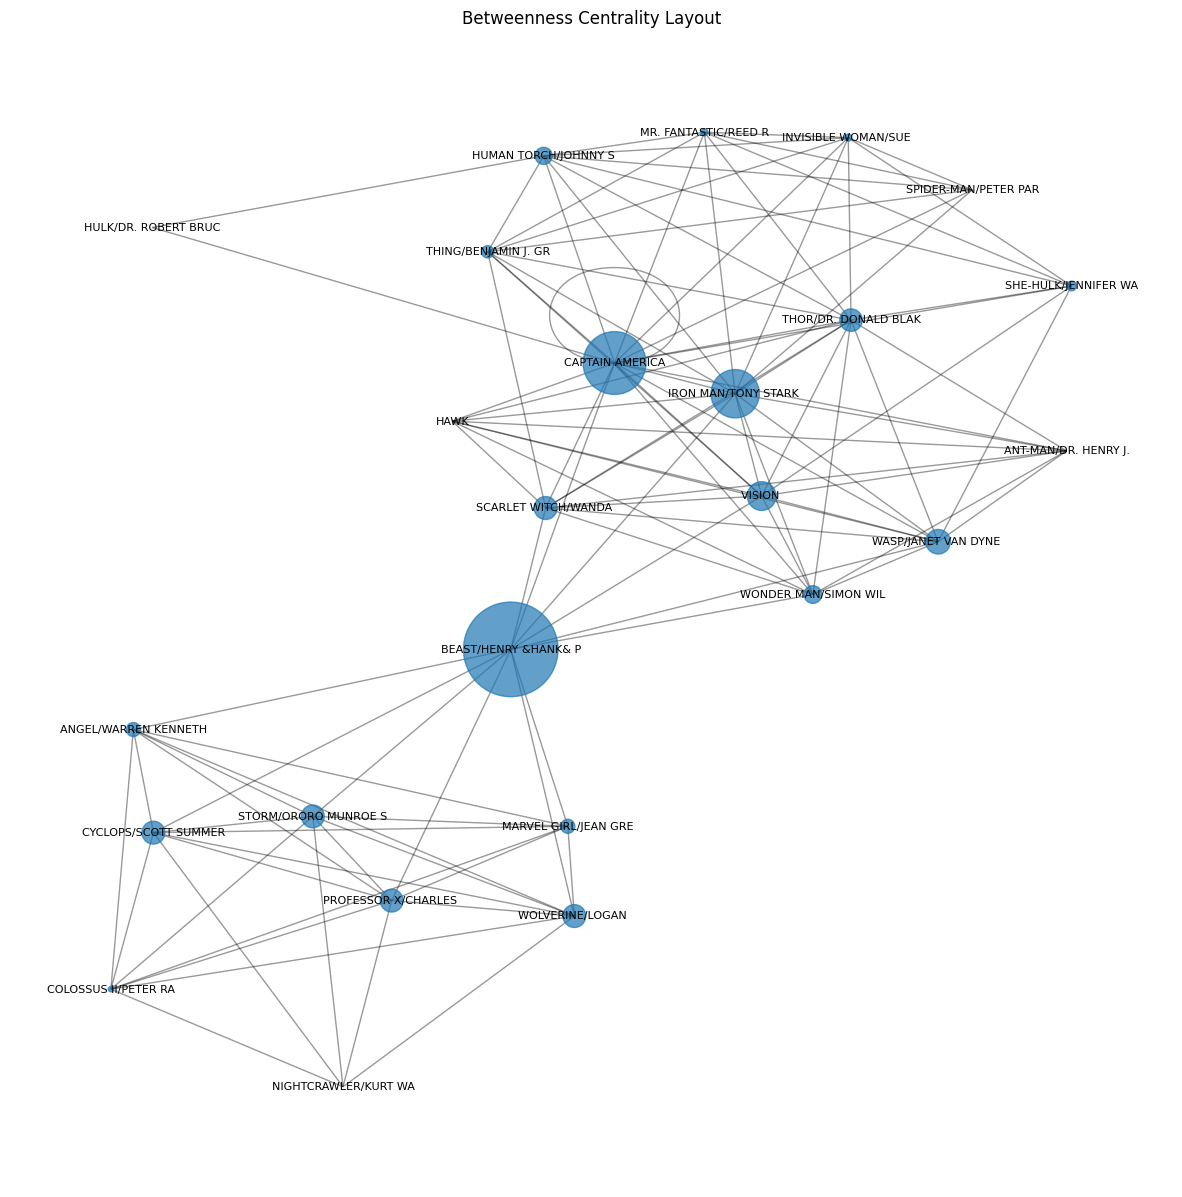

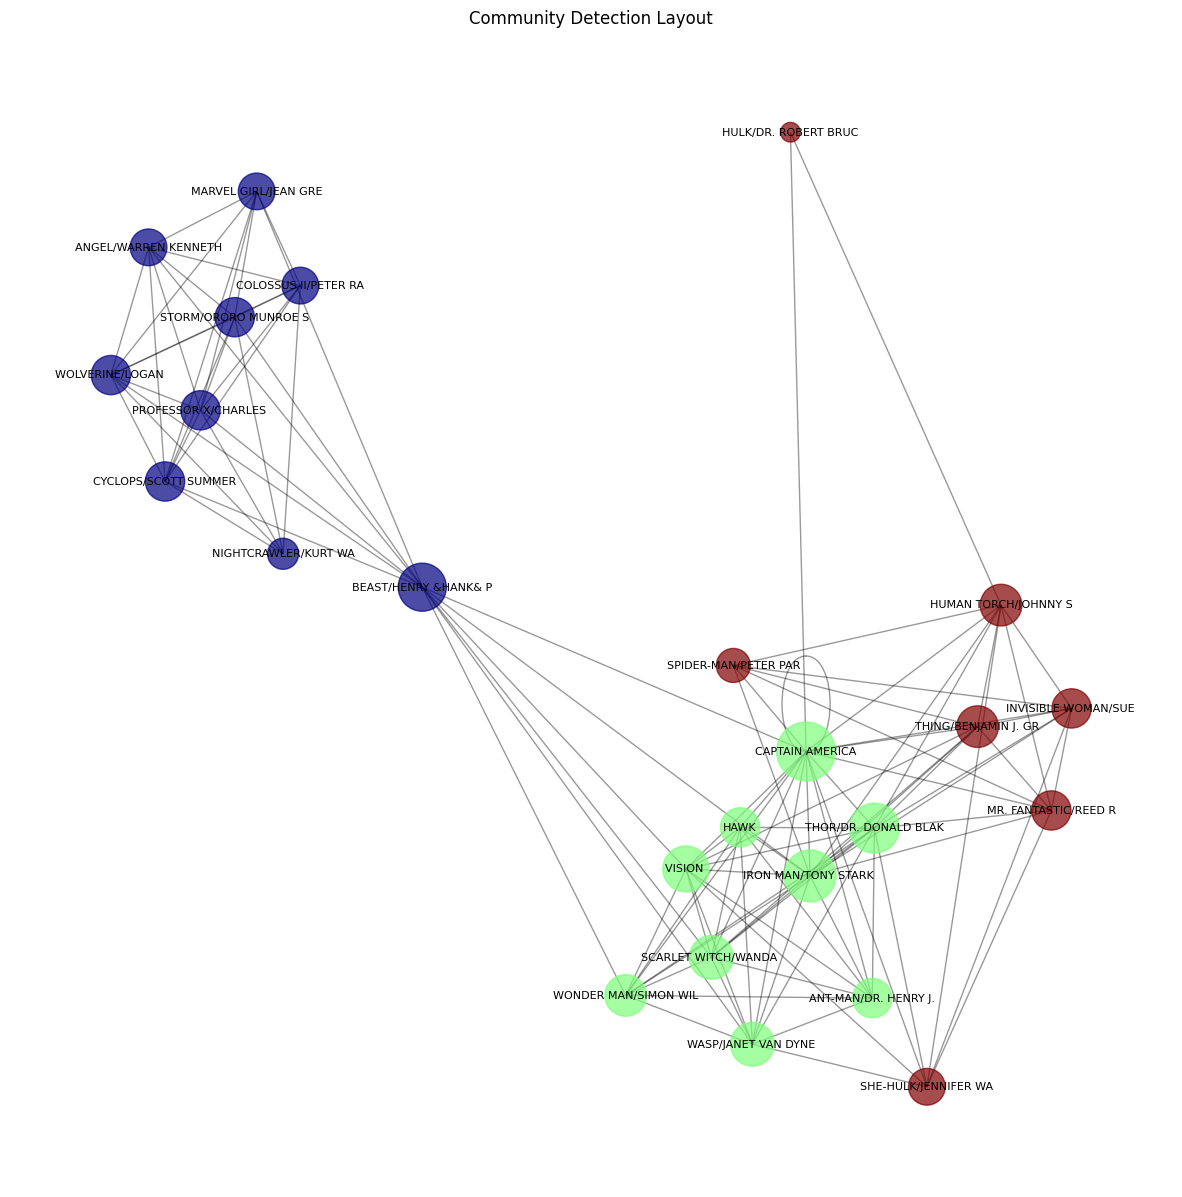

In [ ]:
# ------------------------------------------------------------------------------
# Step 7: Explore different network structures
# ------------------------------------------------------------------------------

# -------------------------------
# Degree Centrality Visualization
# -------------------------------
degree_cent = nx.degree_centrality(H)

# Reclaculate positions
pos_degree = nx.kamada_kawai_layout(H, weight=None)

plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(H, pos_degree, node_size=[v * 10000 for v in degree_cent.values()], alpha=0.7)
nx.draw_networkx_edges(H, pos_degree, alpha=0.4)
nx.draw_networkx_labels(H, pos_degree, font_size=8)
plt.title('Degree Centrality Layout')
plt.axis('off')
plt.show()

# -------------------------------
# Betweenness Centrality Visualization
# -------------------------------
betweenness_cent = nx.betweenness_centrality(H)

# Reclaculate positions
pos_betweenness = nx.kamada_kawai_layout(H, weight=None)

plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(H, pos, node_size=[v * 10000 for v in betweenness_cent.values()], alpha=0.7)
nx.draw_networkx_edges(H, pos, alpha=0.4)
nx.draw_networkx_labels(H, pos, font_size=8)
plt.title('Betweenness Centrality Layout')
plt.axis('off')
plt.show()

# -------------------------------
# Community Detection Visualization
# -------------------------------
partition = community_louvain.best_partition(H)
community_colors = [partition[node] for node in H.nodes()]

plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(H, pos, node_size=[H.degree(node) * 100 for node in H], alpha=0.7, node_color=community_colors, cmap=plt.cm.jet)
nx.draw_networkx_edges(H, pos, alpha=0.4)
nx.draw_networkx_labels(H, pos, font_size=8)
plt.title('Community Detection Layout')
plt.axis('off')
plt.show()

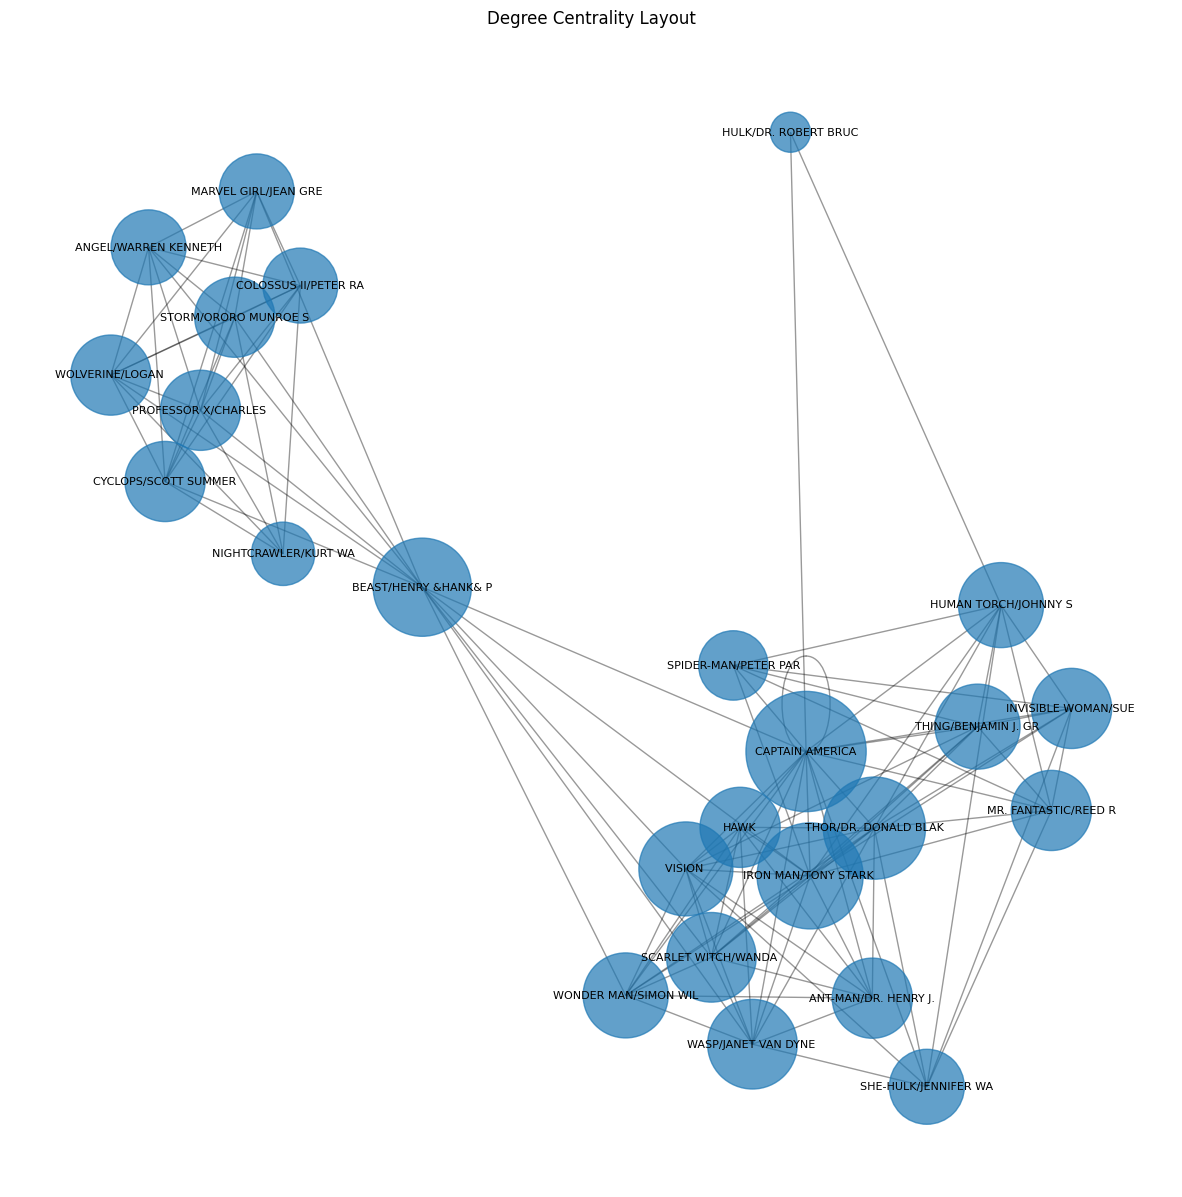

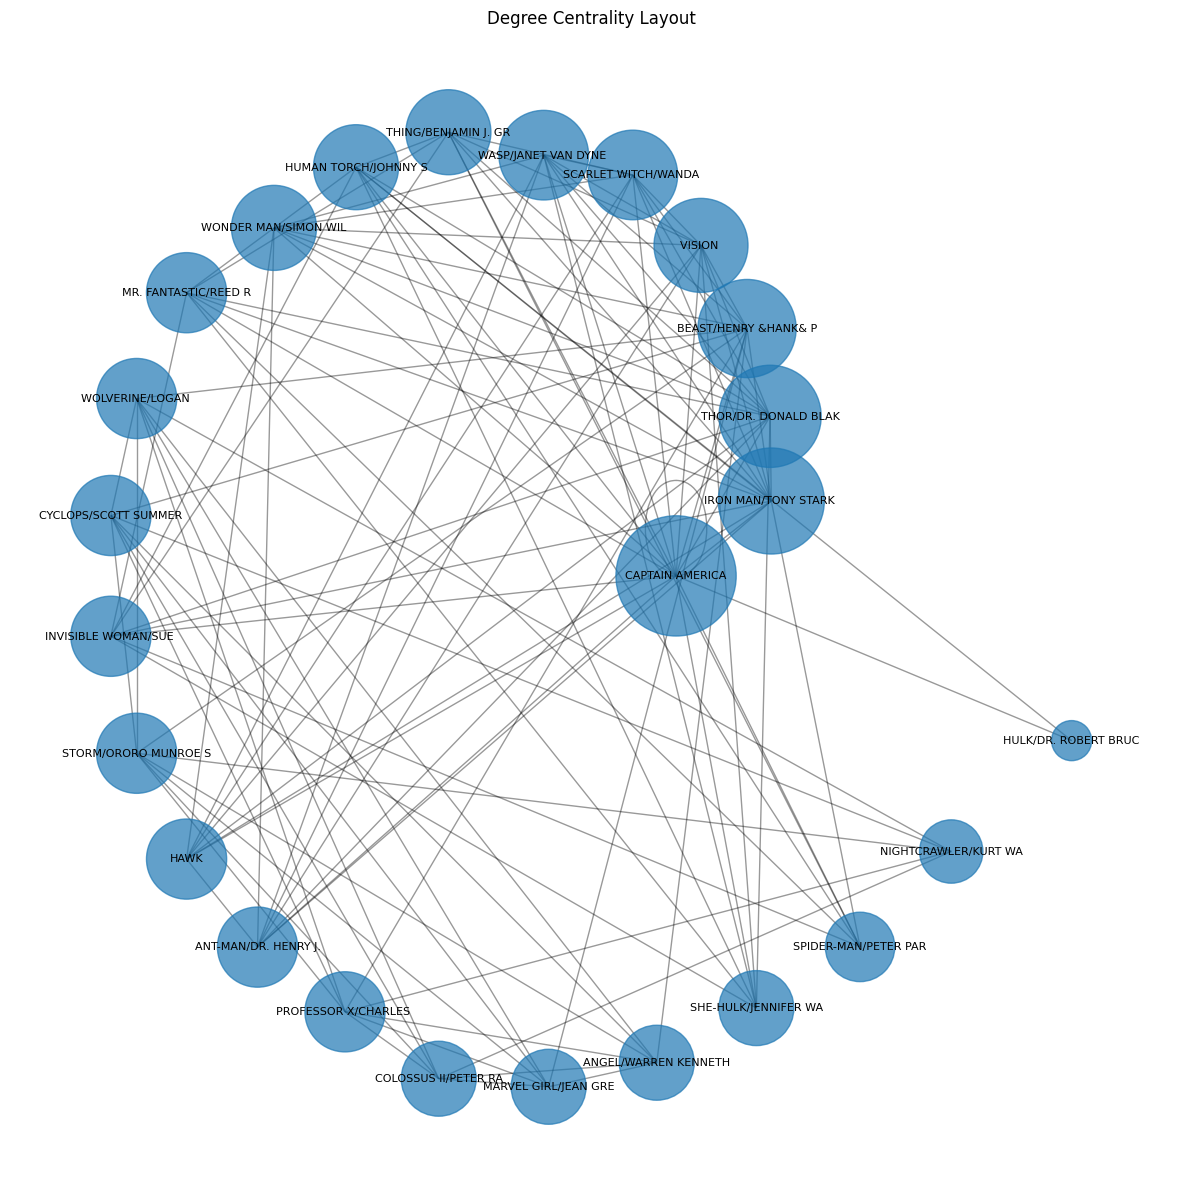

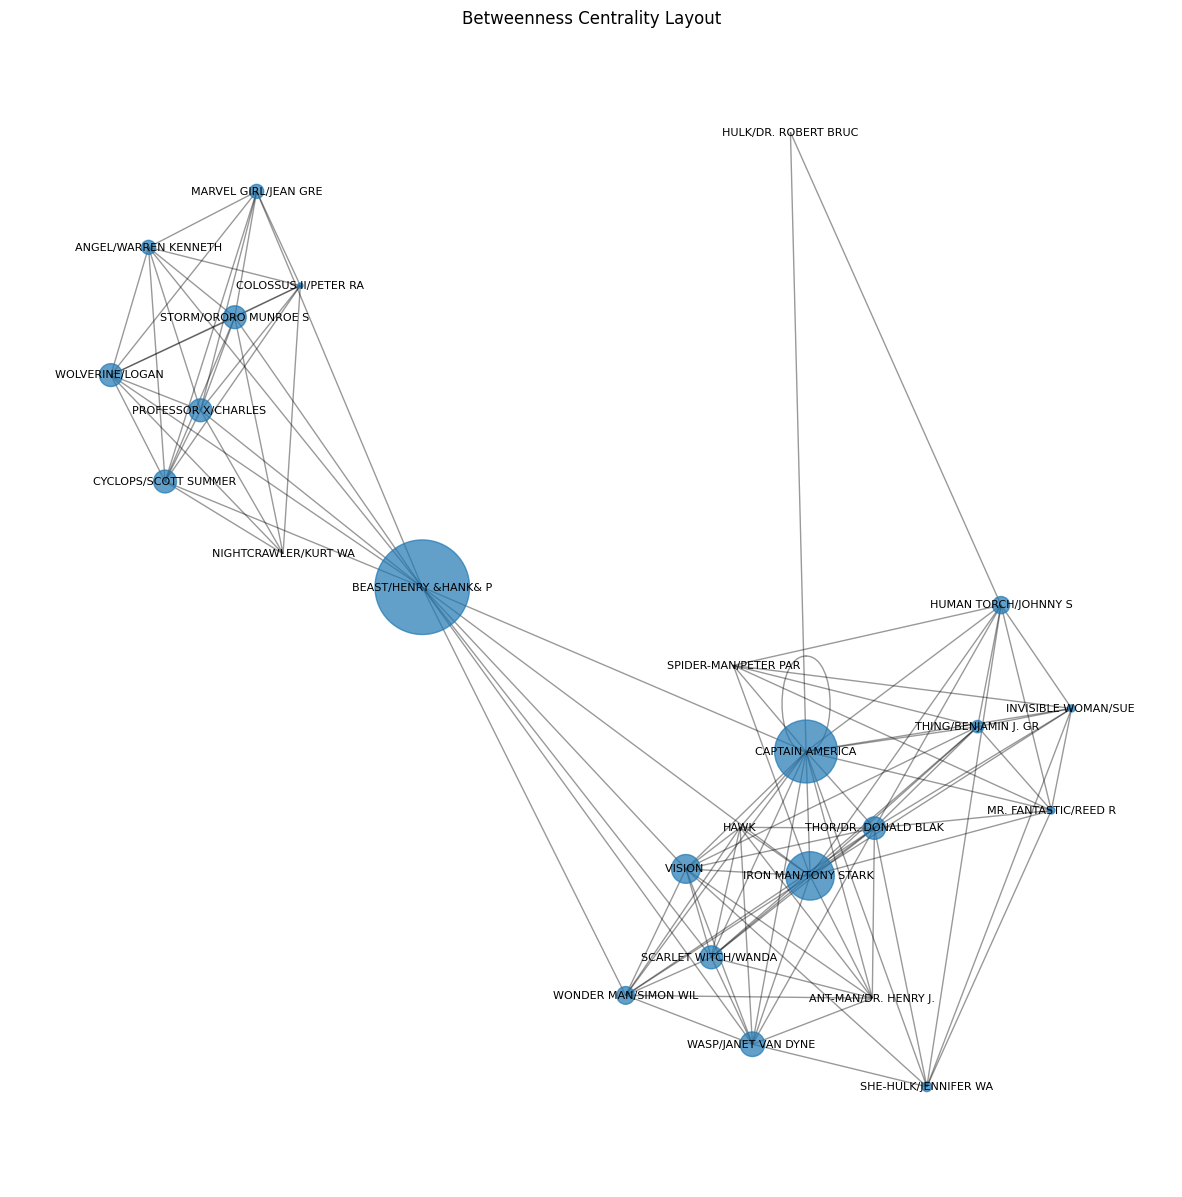

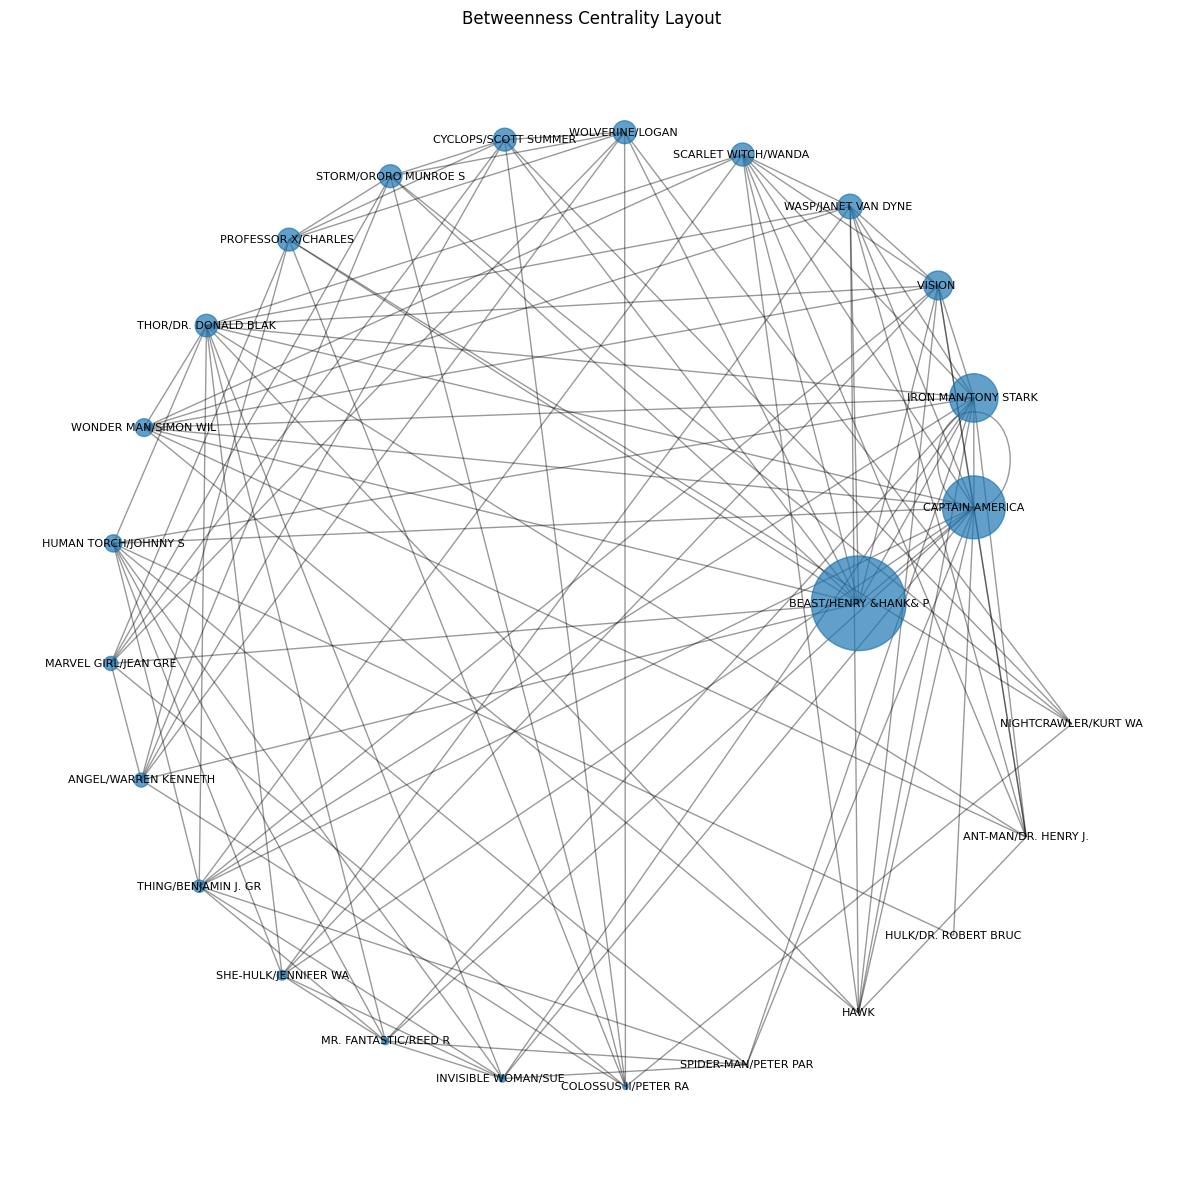

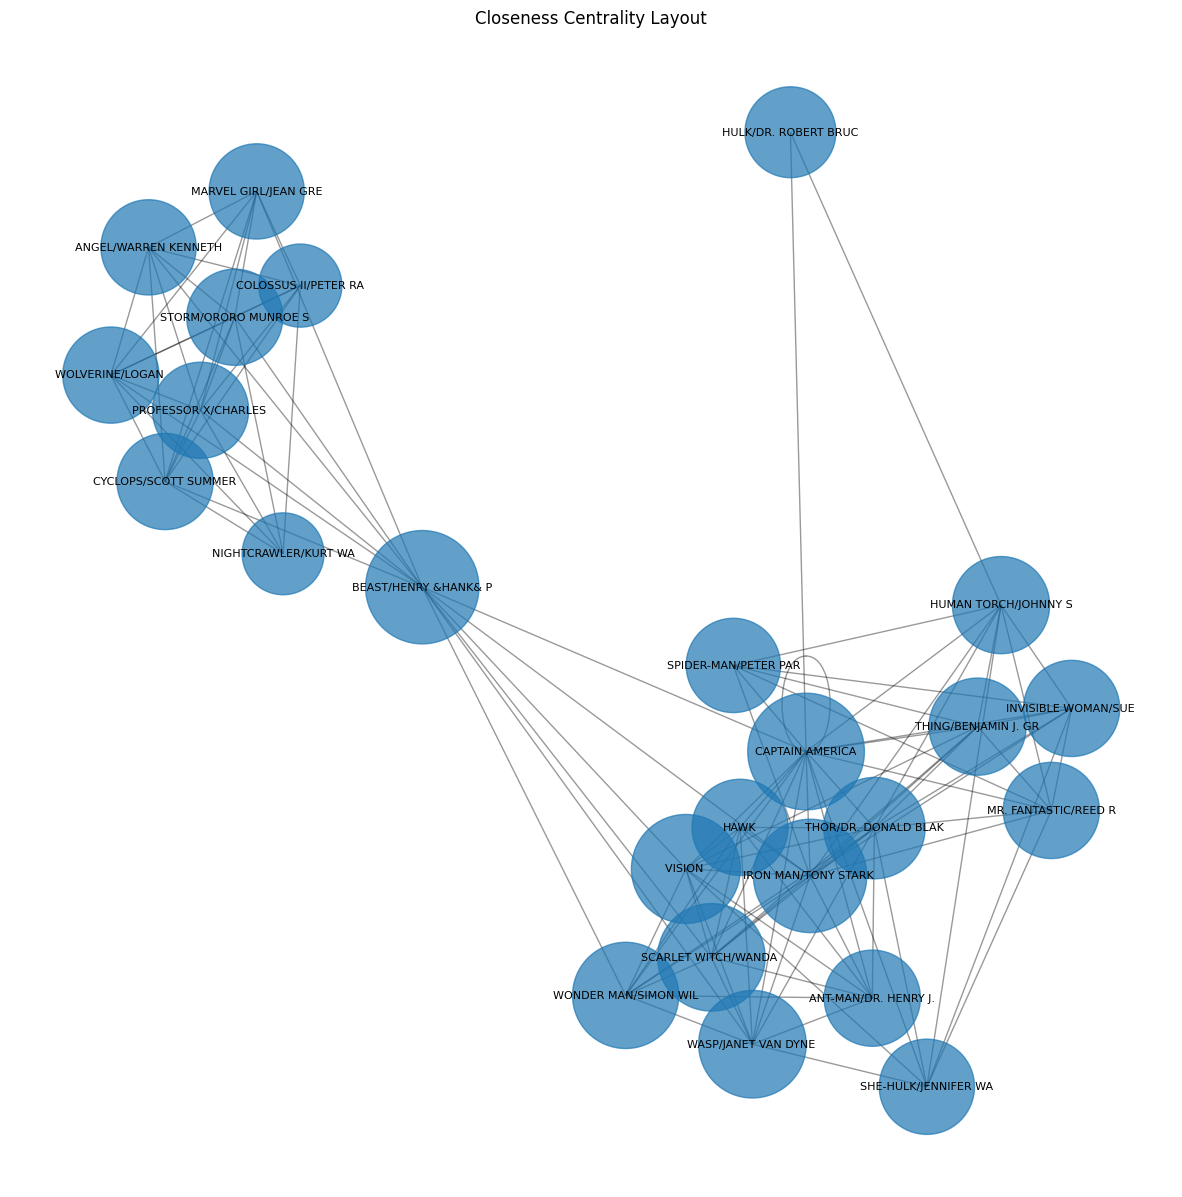

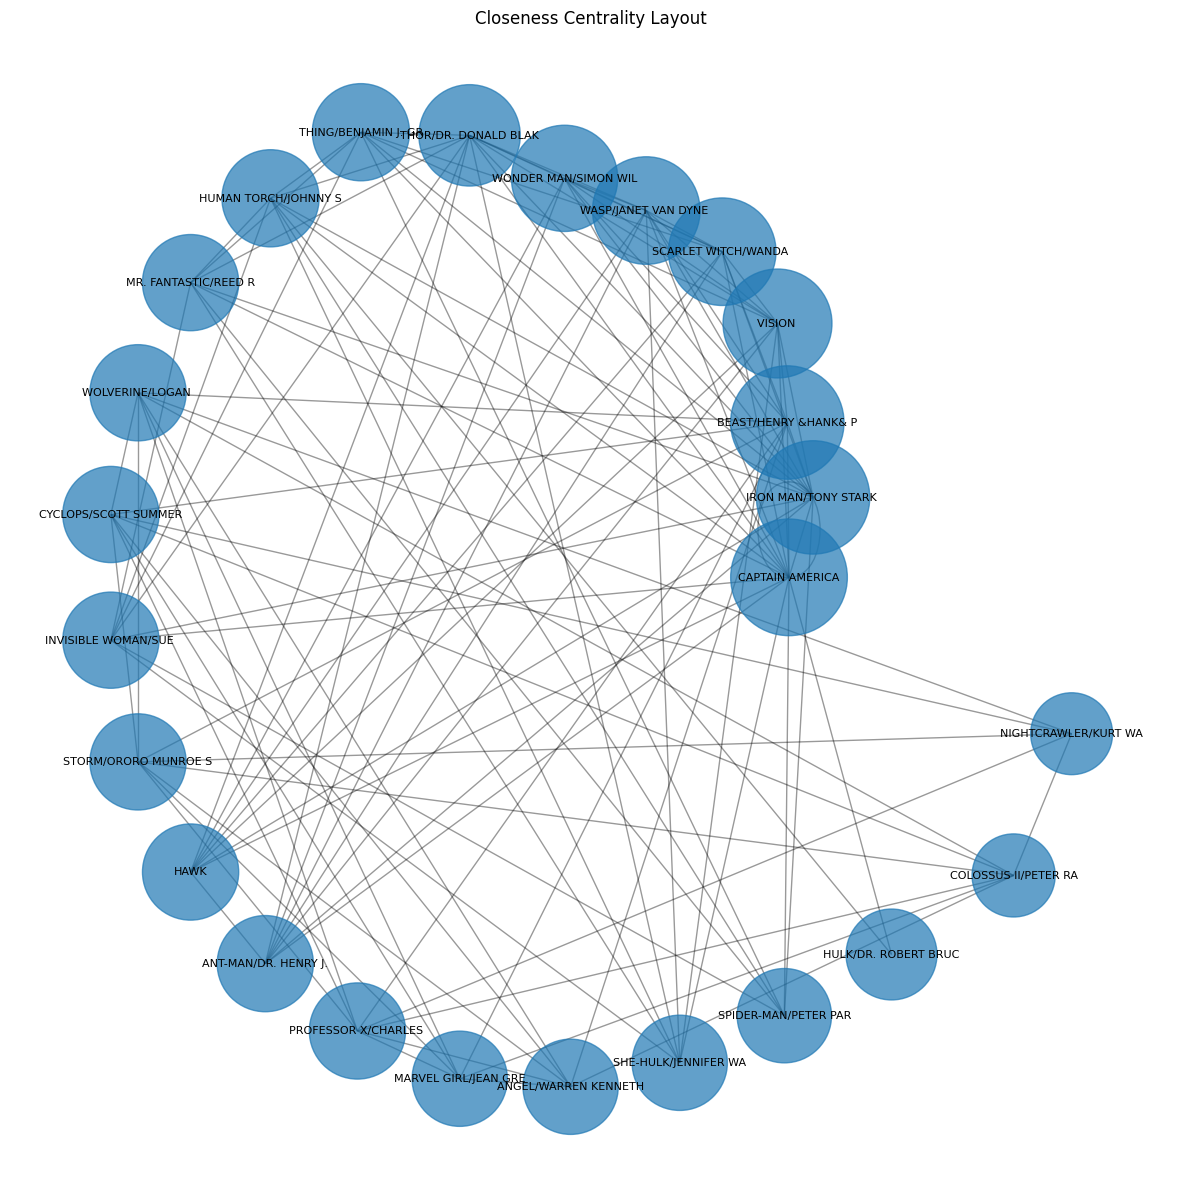

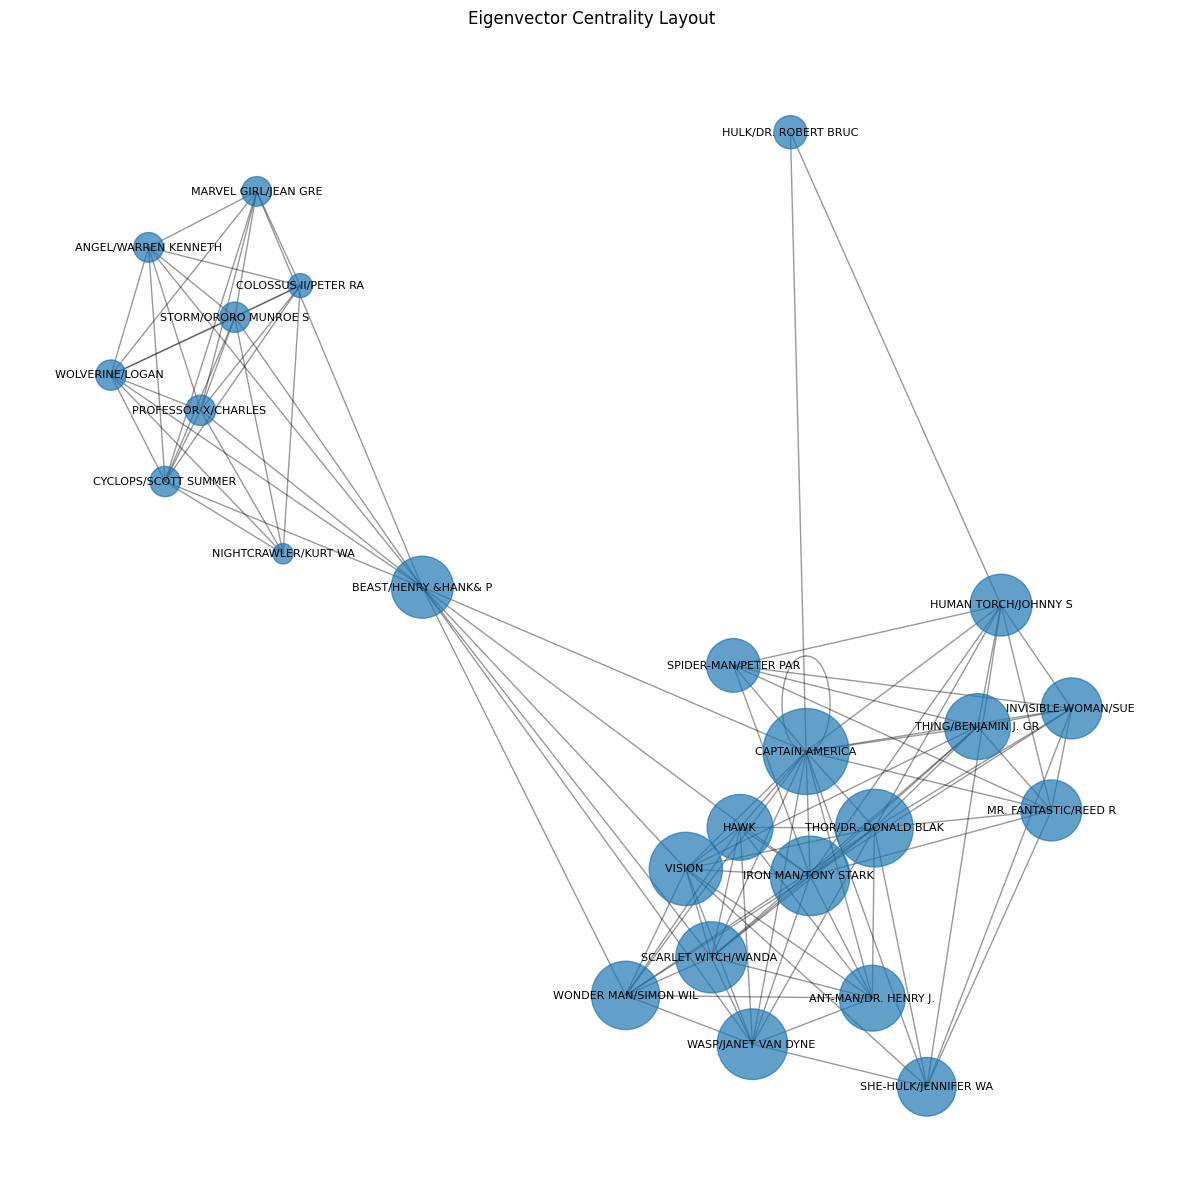

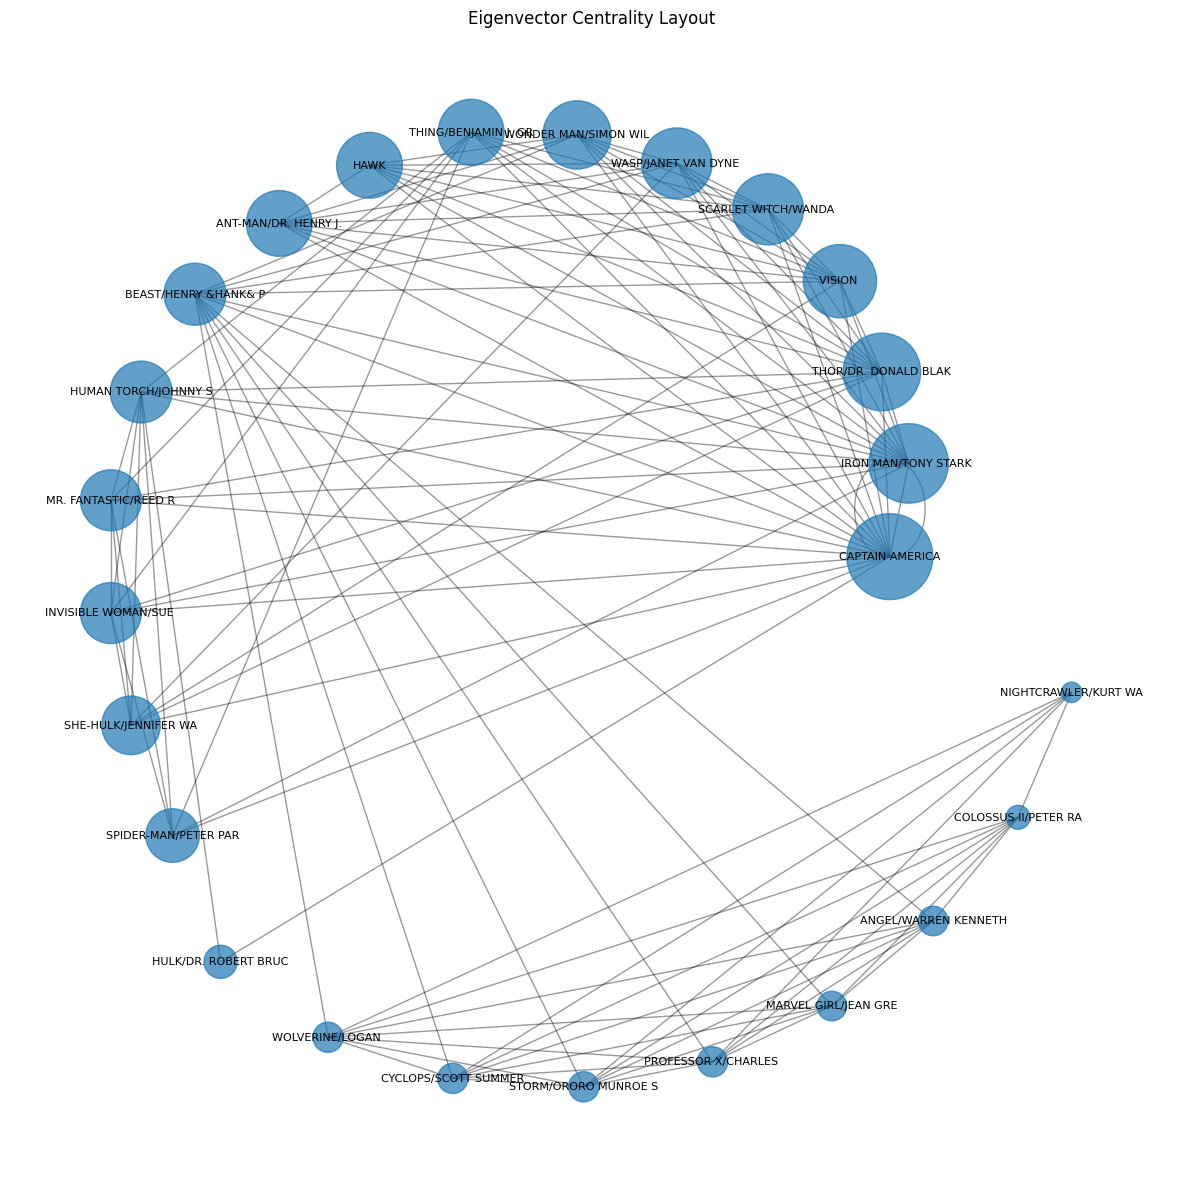

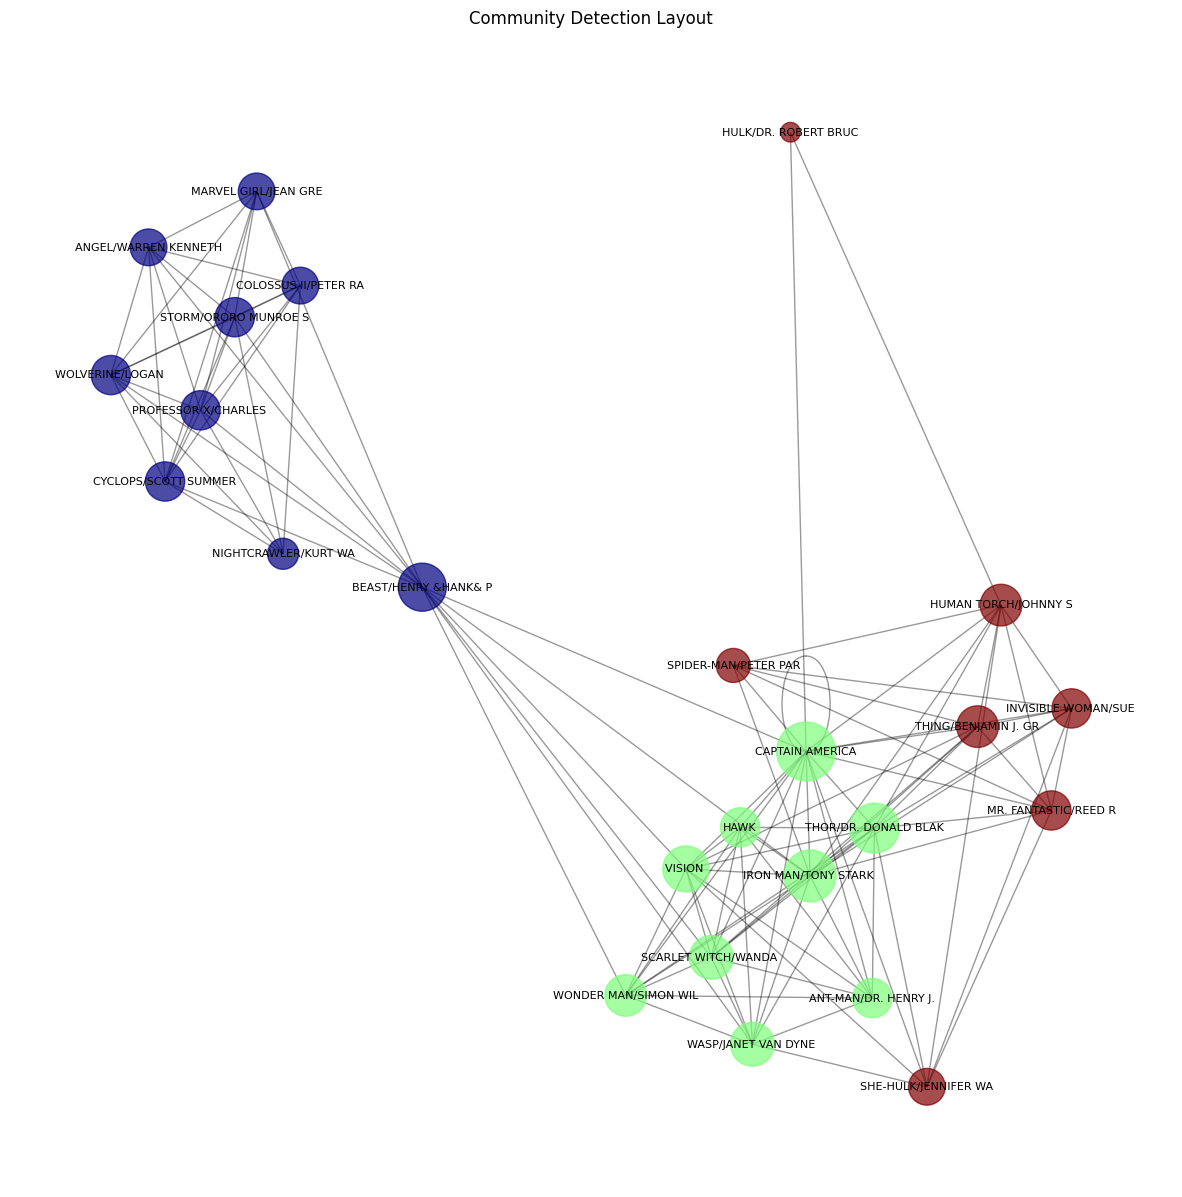

In [ ]:
# ------------------------------------------------------------------------------
# Step 7: Explore different network structures
# ------------------------------------------------------------------------------

# -------------------------------
# Degree Centrality Visualization
# -------------------------------
degree_cent = nx.degree_centrality(H)

plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(H, pos, node_size=[v * 10000 for v in degree_cent.values()], alpha=0.7)
nx.draw_networkx_edges(H, pos, alpha=0.4)
nx.draw_networkx_labels(H, pos, font_size=8)
plt.title('Degree Centrality Layout')
plt.axis('off')
plt.show()

nodes_degree_cent_list = [(node, centr) for node, centr in degree_cent.items()]

# Sort nodes by degree centrality
nodes_degree_cent_list.sort(key=lambda x: x[1], reverse=True)

# Layout for degree centrality
pos_degree = {}
center, radius = np.array([0.5, 0.5]), 0.5  # Center and radius of plot
angle_gap = 2 * np.pi / len(H.nodes())
for i, (node, _) in enumerate(nodes_degree_cent_list):
    angle = i * angle_gap
    pos_degree[node] = center + radius * np.array([np.cos(angle), np.sin(angle)]) * (1 - degree_cent[node])

plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(H, pos_degree, node_size=[v * 10000 for v in degree_cent.values()], alpha=0.7)
nx.draw_networkx_edges(H, pos_degree, alpha=0.4)
nx.draw_networkx_labels(H, pos_degree, font_size=8)
plt.title('Degree Centrality Layout')
plt.axis('off')
plt.show()

# -------------------------------
# Betweenness Centrality Visualization
# -------------------------------
betweenness_cent = nx.betweenness_centrality(H)

plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(H, pos, node_size=[v * 10000 for v in betweenness_cent.values()], alpha=0.7)
nx.draw_networkx_edges(H, pos, alpha=0.4)
nx.draw_networkx_labels(H, pos, font_size=8)
plt.title('Betweenness Centrality Layout')
plt.axis('off')
plt.show()

nodes_betweenness_cent_list = [(node, centr) for node, centr in betweenness_cent.items()]

# Sort nodes by betweenness centrality
nodes_betweenness_cent_list.sort(key=lambda x: x[1], reverse=True)

# Layout for betweenesss centrality
pos_betweenness = {}
for i, (node, _) in enumerate(nodes_betweenness_cent_list):
    angle = i * angle_gap
    pos_betweenness[node] = center + radius * np.array([np.cos(angle), np.sin(angle)]) * (1 - betweenness_cent[node])

plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(H, pos_betweenness, node_size=[v * 10000 for v in betweenness_cent.values()], alpha=0.7)
nx.draw_networkx_edges(H, pos_betweenness, alpha=0.4)
nx.draw_networkx_labels(H, pos_betweenness, font_size=8)
plt.title('Betweenness Centrality Layout')
plt.axis('off')
plt.show()

# -------------------------------
# Closeness Centrality Visualization
# -------------------------------
closeness_cent = nx.closeness_centrality(H)

plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(H, pos, node_size=[v * 10000 for v in closeness_cent.values()], alpha=0.7)
nx.draw_networkx_edges(H, pos, alpha=0.4)
nx.draw_networkx_labels(H, pos, font_size=8)
plt.title('Closeness Centrality Layout')
plt.axis('off')
plt.show()


nodes_closeness_cent_list = [(node, centr) for node, centr in closeness_cent.items()]

# Sort nodes by closeness centrality
nodes_closeness_cent_list.sort(key=lambda x: x[1], reverse=True)

# Layout for closeness centrality
pos_closeness = {}
for i, (node, _) in enumerate(nodes_closeness_cent_list):
    angle = i * angle_gap
    pos_closeness[node] = center + radius * np.array([np.cos(angle), np.sin(angle)]) * (1 - closeness_cent[node])

plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(H, pos_closeness, node_size=[v * 10000 for v in closeness_cent.values()], alpha=0.7)
nx.draw_networkx_edges(H, pos_closeness, alpha=0.4)
nx.draw_networkx_labels(H, pos_closeness, font_size=8)
plt.title('Closeness Centrality Layout')
plt.axis('off')
plt.show()

# -------------------------------
# Eigenvector Centrality Visualization
# -------------------------------
eigenvector_cent = nx.eigenvector_centrality(H)

plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(H, pos, node_size=[v * 10000 for v in eigenvector_cent.values()], alpha=0.7)
nx.draw_networkx_edges(H, pos, alpha=0.4)
nx.draw_networkx_labels(H, pos, font_size=8)
plt.title('Eigenvector Centrality Layout')
plt.axis('off')
plt.show()


nodes_eigenvector_cent_list = [(node, centr) for node, centr in eigenvector_cent.items()]

# Sort nodes by eigenvector centrality
nodes_eigenvector_cent_list.sort(key=lambda x: x[1], reverse=True)

# Layout for eigenvector centrality
pos_eigenvector = {}
for i, (node, _) in enumerate(nodes_eigenvector_cent_list):
    angle = i * angle_gap
    pos_eigenvector[node] = center + radius * np.array([np.cos(angle), np.sin(angle)]) * (1 - eigenvector_cent[node])

plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(H, pos_eigenvector, node_size=[v * 10000 for v in eigenvector_cent.values()], alpha=0.7)
nx.draw_networkx_edges(H, pos_eigenvector, alpha=0.4)
nx.draw_networkx_labels(H, pos_eigenvector, font_size=8)
plt.title('Eigenvector Centrality Layout')
plt.axis('off')
plt.show()

# -------------------------------
# Community Detection Visualization
# -------------------------------
partition = community_louvain.best_partition(H)
community_colors = [partition[node] for node in H.nodes()]

plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(H, pos, node_size=[H.degree(node) * 100 for node in H], alpha=0.7, node_color=community_colors, cmap=plt.cm.jet)
nx.draw_networkx_edges(H, pos, alpha=0.4)
nx.draw_networkx_labels(H, pos, font_size=8)
plt.title('Community Detection Layout')
plt.axis('off')
plt.show()

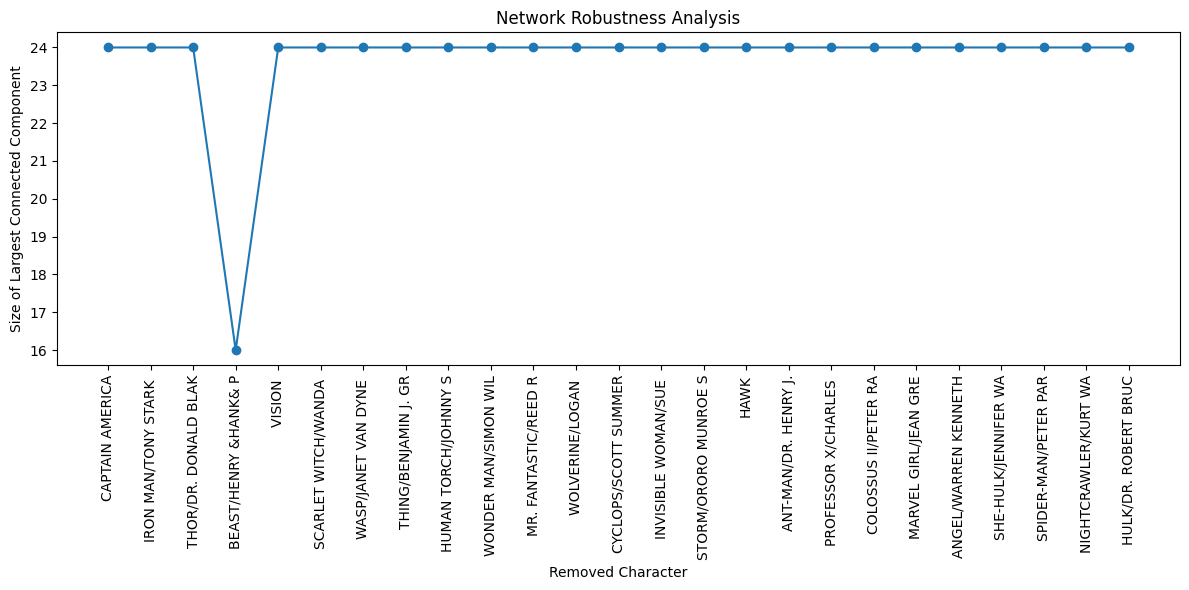

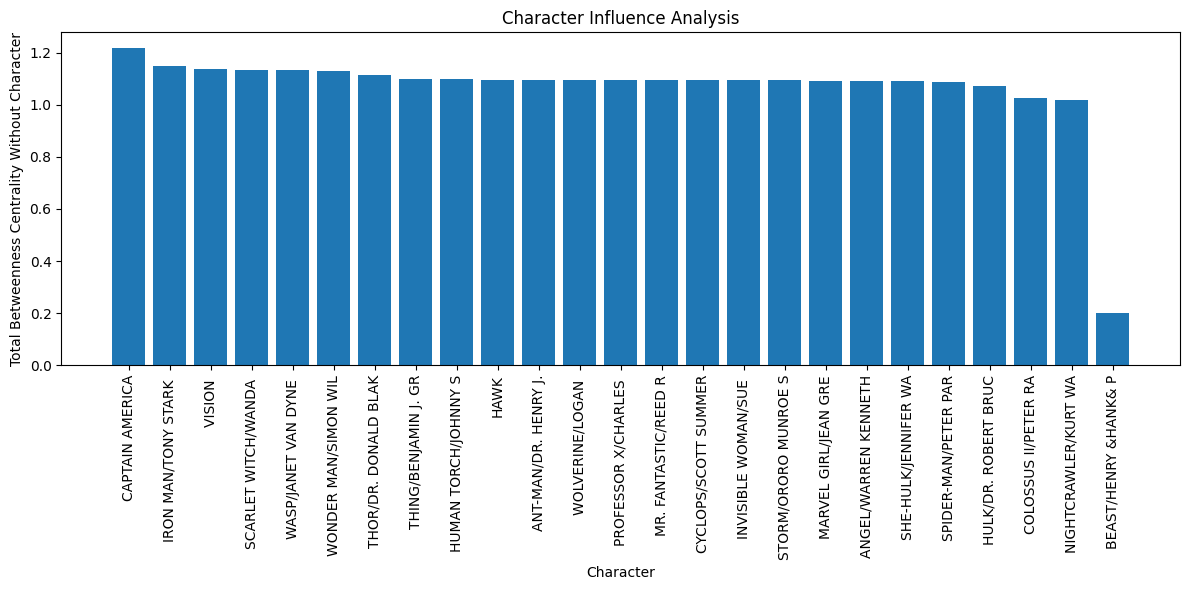

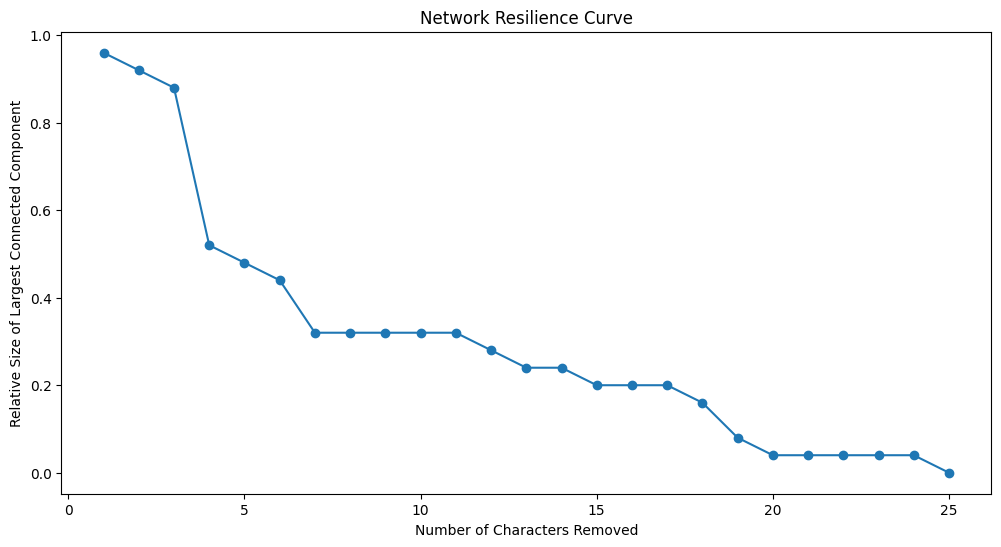

In [ ]:
# ------------------------------------------------------------------------------
# Step 8: Network Robustness and Influence Analysis
# ------------------------------------------------------------------------------

# Identify Key Characters based on Degree Centrality
degree_centrality = nx.degree_centrality(H)
key_characters = sorted(degree_centrality, key=degree_centrality.get, reverse=True)

# Evluates robustness of the network
def evaluate_network_robustness(H, key_characters):
    robustness_report = []
    temp_H = H.copy()
    for character in key_characters:
        # Remove a Character
        temp_H.remove_node(character)
        # Find size of the largest connected component
        largest_cc_size = len(max(nx.connected_components(temp_H), key=len))
        robustness_report.append(largest_cc_size)
        # Revert removal
        temp_H = H.copy()
    return robustness_report

# Evaluate and plot the robustness of the network
robustness_report = evaluate_network_robustness(H, key_characters)
plt.figure(figsize=(12, 6))
plt.plot(key_characters, robustness_report, marker='o')
plt.title('Network Robustness Analysis')
plt.xlabel('Removed Character')
plt.ylabel('Size of Largest Connected Component')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Evaluates influence of character removal
def evaluate_character_influence(H, key_characters):
    influence_report = {}
    for character in key_characters:
        # Calculate the betweenness centrality of the network without the character
        temp_H = H.copy()
        temp_H.remove_node(character)
        betweenness_centrality_without_character = nx.betweenness_centrality(temp_H)
        total_centrality = sum(betweenness_centrality_without_character.values())
        influence_report[character] = total_centrality
    return influence_report

# Get influence report
influence_report = evaluate_character_influence(H, key_characters)
sorted_influence_report = sorted(influence_report.items(), key=lambda item: item[1], reverse=True)

# Plot the influence of characters
plt.figure(figsize=(12, 6))
plt.bar([item[0] for item in sorted_influence_report], [item[1] for item in sorted_influence_report])
plt.title('Character Influence Analysis')
plt.xlabel('Character')
plt.ylabel('Total Betweenness Centrality Without Character')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Evaluate network resilience
def simulate_network_resilience(H, centrality_measure):
    resilience_curve = []
    temp_H = H.copy()
    sorted_nodes = sorted(centrality_measure, key=centrality_measure.get, reverse=True)

    for i in range(1, len(sorted_nodes) + 1):
        nodes_to_remove = sorted_nodes[:i]
        temp_H.remove_nodes_from(nodes_to_remove)
        largest_cc_size = len(max(nx.connected_components(temp_H), key=len)) if nx.number_connected_components(temp_H) > 0 else 0
        resilience_curve.append(largest_cc_size / len(H.nodes()))
    return resilience_curve

# Plot network resilience curve
resilience_curve = simulate_network_resilience(H, degree_cent)
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(H.nodes()) + 1), resilience_curve, marker='o')
plt.title('Network Resilience Curve')
plt.xlabel('Number of Characters Removed')
plt.ylabel('Relative Size of Largest Connected Component')

plt.show()

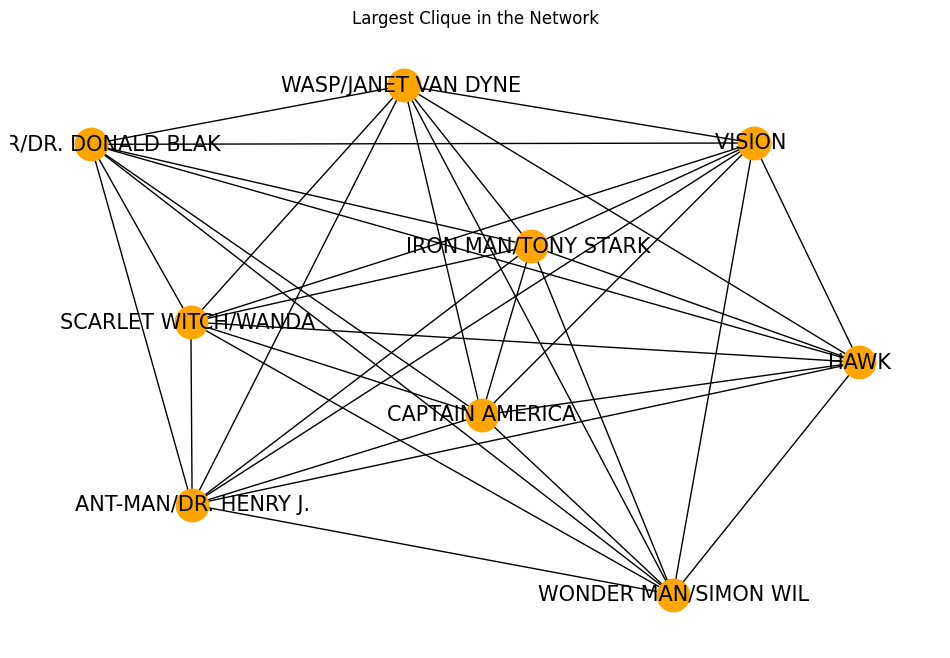

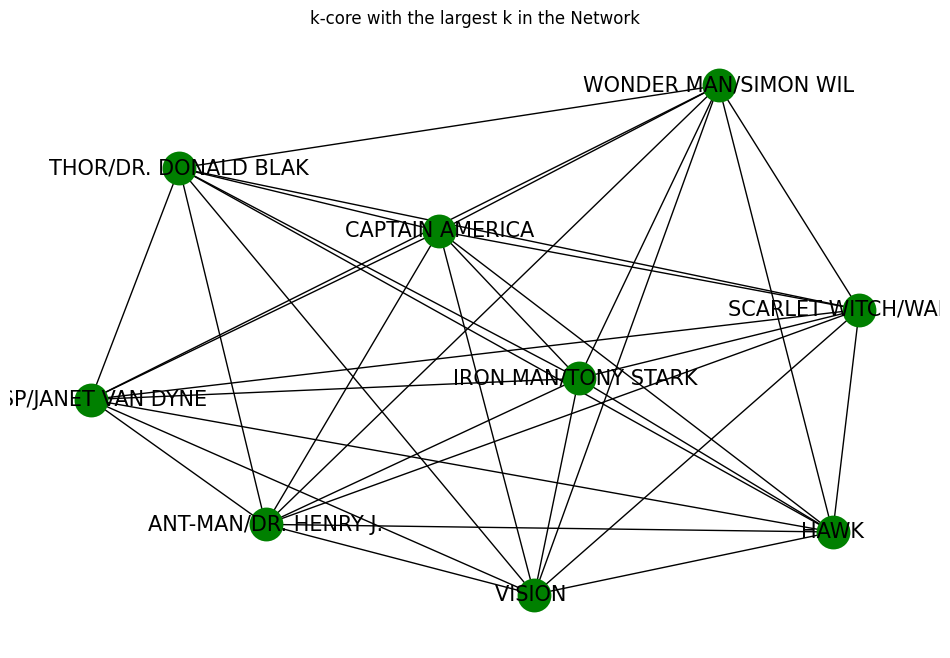

In [ ]:
# A k-core of a network is a maximal connected subgraph in which each vertex has
# at least degree k. It's a subgraph where each node is connected to at least k
# other nodes within the subgraph. This is used to analyze cohesiveness and
# identify tightly connected communities
# ------------------------------------------------------------------------------
# Step 9: Analysis for Character Cliques and Alliances
# ------------------------------------------------------------------------------
cliques = list(nx.find_cliques(H))
largest_clique = max(cliques, key=len)

# Visualize the largest clique
plt.figure(figsize=(12, 8))
clique_graph = H.subgraph(largest_clique)
pos_clique = nx.spring_layout(clique_graph)
nx.draw_networkx(clique_graph, pos_clique, with_labels=True, node_color='orange', node_size=500, edge_color='black', linewidths=2, font_size=15)
plt.title('Largest Clique in the Network')
plt.axis('off')
plt.show()

# Alliance Analysis using k-cores
H.remove_edges_from(nx.selfloop_edges(H))
core_number = nx.core_number(H)
largest_k = max(core_number.values())
k_core_graph = nx.k_core(H, k=largest_k)

# Visualize the k-core
plt.figure(figsize=(12, 8))
pos_k_core = nx.spring_layout(k_core_graph)
nx.draw_networkx(k_core_graph, pos_k_core, with_labels=True, node_color='green', node_size=500, edge_color='black', linewidths=2, font_size=15)
plt.title('k-core with the largest k in the Network')
plt.axis('off')
plt.show()